In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, LayerNormalization, BatchNormalization, Dropout, MultiHeadAttention, TimeDistributed, GlobalAveragePooling1D
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from mutation_multivariate import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
train_x = np.load('spark_0_trace-scl_std/train.npy', allow_pickle=True)
test_x = np.load('spark_0_trace-scl_std/test.npy', allow_pickle=True)
train_y = np.load('spark_0_trace-scl_std/y_train.npy', allow_pickle=True)
test_y = np.load('spark_0_trace-scl_std/y_test.npy', allow_pickle=True)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(52,)
(52,)
(31,)
(31,)


In [4]:
for j, _ in enumerate(test_y):
    test_y[j] = (test_y[j] != 0).astype(int)

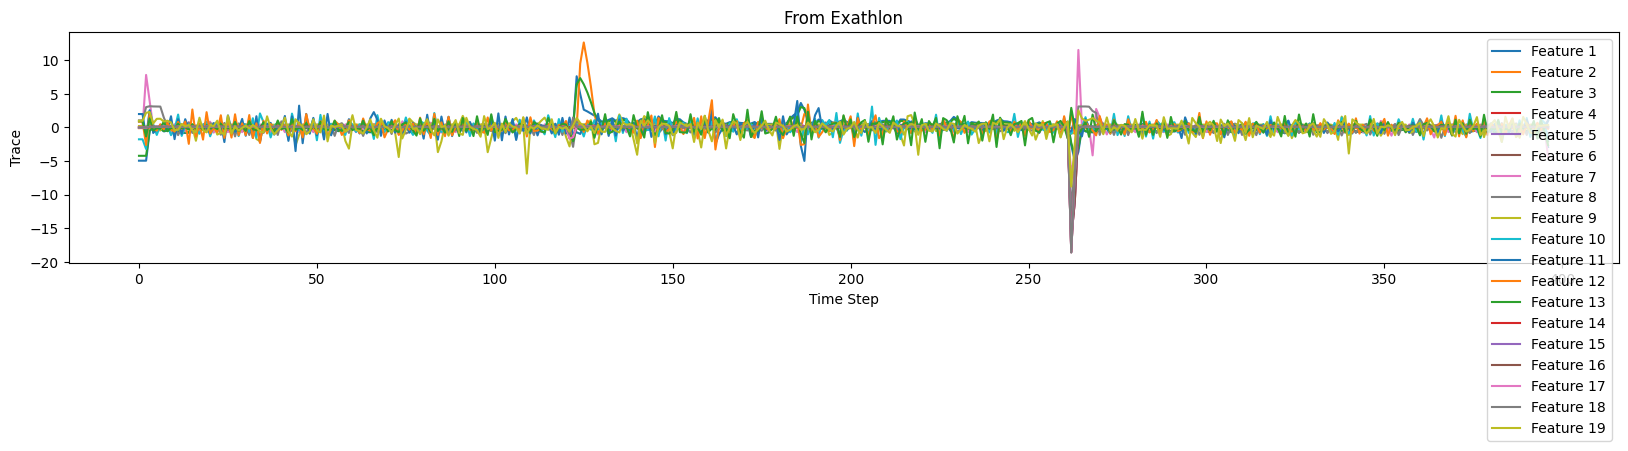

In [10]:
plt.figure(figsize=(20, 3))

# Plot each feature
for i in range(test_x[10].shape[1]):
    plt.plot(test_x[10][:, i], label=f'Feature {i+1}')

plt.xlabel('Time Step')
plt.ylabel('Trace')
plt.title('From Exathlon')
plt.legend()
plt.show()


# Semi Supervised Modelling

**LSTM autoencoder**

In [8]:
def create_lstm_autoencoder(input_shape):
    inputs = Input(shape=(input_shape[1], input_shape[2]))
    
    # Encoder
    encoded = LSTM(32, activation='relu', return_sequences=True)(inputs)
    encoded = Dropout(0.1)(encoded)
    encoded = LSTM(16, activation='relu')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = RepeatVector(input_shape[1])(encoded)
    
    # Decoder
    decoded = LSTM(16, activation='relu', return_sequences=True)(encoded)
    decoded = Dropout(0.1)(decoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = BatchNormalization()(decoded)
    
    outputs = TimeDistributed(Dense(input_shape[2]))(decoded)
    
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

# Preprocess data
scaler = StandardScaler()
train_data_x = np.concatenate(train_x, axis=0)
train_data_x = scaler.fit_transform(train_data_x.reshape(-1, train_data_x.shape[-1]))

# Reshape data to have shape (samples, time steps, features)
time_steps = 30  # choose an appropriate time step length
train_data_x = train_data_x.reshape(-1, time_steps, train_data_x.shape[-1])
input_shape = train_data_x.shape


# Create and train the model with EarlyStopping
autoencoder = create_lstm_autoencoder(input_shape)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
autoencoder.fit(train_data_x, train_data_x, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], shuffle = False)

auc_scores = []


for test_record, true_values in zip(test_x, test_y):
    test_record = scaler.transform(test_record.reshape(-1, test_record.shape[-1]))

    # Pad the test_record to be a multiple of time_steps
    if len(test_record) % time_steps != 0:
        pad_length = time_steps - (len(test_record) % time_steps)
        test_record = np.pad(test_record, ((0, pad_length), (0, 0)), 'constant')

    test_record = test_record.reshape(-1, time_steps, test_record.shape[-1])
    
    predictions = autoencoder.predict(test_record)
    
    predictions = predictions.reshape(-1, predictions.shape[-1])[:len(true_values)]
    predictions = predictions.mean(axis=1)
    # true_values = true_values.reshape(-1, true_values.shape[-1])[:len(true_values)]

    auc_pr = get_auc_pr(predictions, true_values)
        
    auc_scores.append(auc_pr)
    
    
print(f"AUC-PR: {np.mean(auc_scores)}")


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1.5072 - val_loss: 1.3336
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.0719 - val_loss: 1.2977
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0266 - val_loss: 1.0099
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.0161 - val_loss: 1.0149
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.0085 - val_loss: 0.9938
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.0081 - val_loss: 0.9934
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.0055 - val_loss: 1.1559
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0015 - val_loss: 2.8924
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.9979 - val_loss: 13.7429
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9963 - val_loss: 29.3783
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9954 - val_loss: 33.2592
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 

**Transformer**

In [6]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def create_transformer_autoencoder(input_shape, embed_dim=30, num_heads=4, ff_dim=128, num_layers=4, rate=0.1):
    time_steps, num_features = input_shape[1], input_shape[2]

    inputs = Input(shape=(time_steps, num_features))
    x = Dense(embed_dim)(inputs)  # Ensure input dimension matches embed_dim
    for _ in range(num_layers):
        x = TransformerEncoderLayer(embed_dim, num_heads, ff_dim, rate)(x, training=True)
    
    encoded = GlobalAveragePooling1D()(x)
    encoded = Dense(embed_dim, activation='relu')(encoded)

    # Decoding part
    decoded = RepeatVector(time_steps)(encoded)
    for _ in range(num_layers):
        decoded = TransformerEncoderLayer(embed_dim, num_heads, ff_dim, rate)(decoded, training=True)
    
    decoded = TimeDistributed(Dense(num_features))(decoded)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Example reshaping of train_data_x
time_steps = 30

scaler = StandardScaler()
train_data_x = np.concatenate(train_x, axis=0)
train_data_x = scaler.fit_transform(train_data_x.reshape(-1, train_data_x.shape[-1]))

# Ensure there is enough data to reshape
if len(train_data_x) >= time_steps:
    num_samples = (len(train_data_x) // time_steps) * time_steps
    train_data_x = train_data_x[:num_samples]  # Truncate to a multiple of time_steps
    num_features = train_data_x.shape[1]
    train_data_x = train_data_x.reshape(-1, time_steps, num_features)
    input_shape = train_data_x.shape


    autoencoder = create_transformer_autoencoder(input_shape)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    autoencoder.fit(train_data_x, train_data_x, epochs=100, batch_size=32, validation_split=0.2, shuffle=False, 
                    callbacks=[early_stopping])

    auc_scores = []

    for test_record, true_values in zip(test_x, test_y):
        padded_length = ((len(test_record) // time_steps) + 1) * time_steps
        padded_test_record = np.pad(test_record, ((0, padded_length - len(test_record)), (0, 0)), mode='constant')
        padded_test_record = padded_test_record.reshape(-1, time_steps, num_features)
        predictions = autoencoder.predict(padded_test_record)
        
        predictions = predictions.reshape(-1, predictions.shape[-1])[:len(true_values)]
        true_values = true_values.reshape(-1, true_values.shape[-1])[:len(true_values)]
        predictions = predictions.mean(axis=1)
        
        auc_pr = get_auc_pr(predictions, true_values)
        
        auc_scores.append(auc_pr)
    
    print(f'Average AUC-PR: {np.mean(auc_scores)}')
else:
    print("Not enough data to reshape for the specified time_steps.")


Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - loss: 1.2281 - val_loss: 0.9740
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 1.0138 - val_loss: 0.9772
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 1.0081 - val_loss: 0.9809
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 1.0019 - val_loss: 0.9830
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.9846 - val_loss: 0.9517
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.9733 - val_loss: 0.9788
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.9730 - val_loss: 0.9759
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.9749 - val_loss: 0.9855
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.9778 - val_loss: 0.9997
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.9669 - val_loss: 0.9781
Epoch 11/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.9620 - val_loss: 1.0026
Epoch 12/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/ste

# Time Series Modeling - Statistical Modeling

**ADF and KPSS tests**

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(series, regression='ct'):
    result = adfuller(series, regression=regression)
    return result[1]  # Return p-value

def kpss_test(series, regression='ct'):
    result = kpss(series, regression=regression)
    return result[1]  # Return p-value

def stationarity_check(series, regression='ct'):
    p_adf = adf_test(series, regression)
    p_kpss = kpss_test(series, regression)
    if p_adf < 0.05 and p_kpss >= 0.05:
        return True  # Stationary
    else:
        return False  # Not stationary


def multivariate_stationarity(train_x):
    for index, sample in enumerate(train_x):
        print(f'working with time series {index+1}')
        for feature_index in range(sample.shape[1]):  
            feature_data = sample[:, feature_index] 
            
            bool_val =  stationarity_check(feature_data)
            
            if bool_val == False:
                print(f'detreding starts for feature {feature_index}')
                log_series = np.log(feature_data) # log transformation
                log_series[np.isnan(log_series)] = 0
                bool_val = stationarity_check(log_series)
                if bool_val == True:
                    sample[:, feature_index] = log_series
                else:
                    log_series = pd.Series(log_series)
                    log_series_diff_1 = log_series.diff().fillna(0) # first order differencing.
    
                    bool_val = stationarity_check(log_series_diff_1)
                    if bool_val == True:
                        sample[:, feature_index] = log_series_diff_1.values
                    else:
                        log_series_diff_2 = log_series_diff_1.diff().fillna(0) # second order differencing
                        bool_val = stationarity_check(log_series_diff_2)
                        if bool_val == True:
                            sample[:, feature_index] = log_series_diff_2.values
                        else:
                            log_series_diff_3 = log_series_diff_2.diff().fillna(0) # third order differencing
                            bool_val = stationarity_check(log_series_diff_3)
                            if bool_val == True:
                                sample[:, feature_index] = log_series_diff_3.values
                            else:
                                print('can not detrend this feature.')
                            

multivariate_stationarity(train_x)


working with time series 1
detreding starts for feature 6
detreding starts for feature 7
detreding starts for feature 9
detreding starts for feature 13
detreding starts for feature 14
detreding starts for feature 15
detreding starts for feature 16
detreding starts for feature 17
working with time series 2
detreding starts for feature 0


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 2
detreding starts for feature 3
detreding starts for feature 5
detreding starts for feature 6
detreding starts for feature 9
detreding starts for feature 13
detreding starts for feature 14
detreding starts for feature 15
detreding starts for feature 16
detreding starts for feature 17
working with time series 3


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result

detreding starts for feature 0
detreding starts for feature 2
detreding starts for feature 8


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 12
detreding starts for feature 13
detreding starts for feature 14
detreding starts for feature 15
detreding starts for feature 16


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result

detreding starts for feature 17
working with time series 4
detreding starts for feature 3
detreding starts for feature 4
detreding starts for feature 5
detreding starts for feature 6
working with time series 5


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 4
detreding starts for feature 5
detreding starts for feature 9


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 15
working with time series 6
detreding starts for feature 4
detreding starts for feature 5
detreding starts for feature 6
detreding starts for feature 14
detreding starts for feature 15
working with time series 7


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 0
detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 7


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 13
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 15
detreding starts for feature 16


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 17
working with time series 8
detreding starts for feature 0


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 13
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 15


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 16
detreding starts for feature 17


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.

working with time series 9
detreding starts for feature 0
detreding starts for feature 2
detreding starts for feature 4
detreding starts for feature 5
detreding starts for feature 6
detreding starts for feature 7


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/home/fazle/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/home/fazle/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf

detreding starts for feature 13
detreding starts for feature 14
detreding starts for feature 15
detreding starts for feature 16
working with time series 10


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 13
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 15
detreding starts for feature 16


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

working with time series 11
detreding starts for feature 0
detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 13
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 15
detreding starts for feature 16


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

working with time series 12
detreding starts for feature 0
detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 11
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 15
detreding starts for feature 17


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

working with time series 13
detreding starts for feature 0
detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 13
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.

detreding starts for feature 15
working with time series 14
detreding starts for feature 0


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.

detreding starts for feature 1
detreding starts for feature 2
detreding starts for feature 3


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 4
detreding starts for feature 5


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result

detreding starts for feature 14
detreding starts for feature 15


/home/fazle/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


working with time series 15
detreding starts for feature 3


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 14
working with time series 16


/home/fazle/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: Ru

detreding starts for feature 0
detreding starts for feature 1
detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 13
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.

working with time series 17
detreding starts for feature 0
detreding starts for feature 2
detreding starts for feature 3
detreding starts for feature 4
detreding starts for feature 5
detreding starts for feature 7
detreding starts for feature 10


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/home/fazle/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarni

detreding starts for feature 14
detreding starts for feature 15
working with time series 18
detreding starts for feature 1


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 14
detreding starts for feature 15


/home/fazle/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


working with time series 19


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

working with time series 20
detreding starts for feature 0
detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 3
detreding starts for feature 5


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 13
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 15
working with time series 21


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 0
detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.

detreding starts for feature 4
detreding starts for feature 5


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 14
detreding starts for feature 15
detreding starts for feature 17


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result

working with time series 22
detreding starts for feature 0
detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 10
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 15
working with time series 23
detreding starts for feature 3
detreding starts for feature 4


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/home/fazle/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/hom

detreding starts for feature 5
detreding starts for feature 6
detreding starts for feature 11
detreding starts for feature 15
working with time series 24
detreding starts for feature 0
detreding starts for feature 2
detreding starts for feature 4
detreding starts for feature 5
detreding starts for feature 6
detreding starts for feature 11
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result

detreding starts for feature 15
working with time series 25
detreding starts for feature 5


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 14
detreding starts for feature 15


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

working with time series 26
detreding starts for feature 3
detreding starts for feature 4
detreding starts for feature 5
detreding starts for feature 6
detreding starts for feature 7
detreding starts for feature 13
detreding starts for feature 14
detreding starts for feature 15
detreding starts for feature 16
detreding starts for feature 17
working with time series 27


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result

detreding starts for feature 12
detreding starts for feature 14
detreding starts for feature 15
working with time series 28
detreding starts for feature 4
detreding starts for feature 5
detreding starts for feature 6
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

working with time series 29
detreding starts for feature 0
detreding starts for feature 2
detreding starts for feature 3
detreding starts for feature 4
detreding starts for feature 5
detreding starts for feature 6
detreding starts for feature 10
detreding starts for feature 13
detreding starts for feature 16
detreding starts for feature 17
detreding starts for feature 18
working with time series 30
detreding starts for feature 4
detreding starts for feature 5
detreding starts for feature 12
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.

working with time series 31
detreding starts for feature 1
detreding starts for feature 3


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test s

detreding starts for feature 4
detreding starts for feature 5


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 10
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.

detreding starts for feature 15
working with time series 32
detreding starts for feature 4
detreding starts for feature 5


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 10
detreding starts for feature 16
detreding starts for feature 17
working with time series 33


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 4


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 5


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 13
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

working with time series 34
detreding starts for feature 0
detreding starts for feature 2
detreding starts for feature 4
detreding starts for feature 5
detreding starts for feature 11


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.

detreding starts for feature 14
detreding starts for feature 15
working with time series 35
detreding starts for feature 0


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 13


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 15
detreding starts for feature 17
working with time series 36


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

working with time series 37
detreding starts for feature 1


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 10
detreding starts for feature 12


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/home/fazle/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. T

detreding starts for feature 15
working with time series 38
detreding starts for feature 0


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 1


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 13
detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 15


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

working with time series 39
detreding starts for feature 0
detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 3
detreding starts for feature 5
detreding starts for feature 8


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 14
detreding starts for feature 15


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

working with time series 40
detreding starts for feature 3
detreding starts for feature 4
detreding starts for feature 9
detreding starts for feature 10
detreding starts for feature 13
detreding starts for feature 14
detreding starts for feature 15
working with time series 41


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 0


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 13


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 15


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 16


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

working with time series 42
detreding starts for feature 0


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 2
detreding starts for feature 3


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 14
detreding starts for feature 15
working with time series 43


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 13


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 15


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 16


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

working with time series 44
detreding starts for feature 0


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 13


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 15


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 16


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


working with time series 45


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 1
detreding starts for feature 3


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 4
detreding starts for feature 5


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 7


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 13


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

working with time series 46
detreding starts for feature 0
detreding starts for feature 2
detreding starts for feature 3


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result

detreding starts for feature 4
detreding starts for feature 5


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result

detreding starts for feature 7


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 13


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/home/fazle/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: Ru

detreding starts for feature 18
working with time series 47


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 3


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 7


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 14
detreding starts for feature 17


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 18
working with time series 48
detreding starts for feature 0


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 1
detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 7


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 13
detreding starts for feature 15


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/home/fazle/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarni

working with time series 49
detreding starts for feature 1
detreding starts for feature 5


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 7


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation


detreding starts for feature 14


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/home/fazle/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: Ru

detreding starts for feature 18
working with time series 50
detreding starts for feature 4


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 7
detreding starts for feature 13


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 14
working with time series 51
detreding starts for feature 0


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 4
detreding starts for feature 5


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.

detreding starts for feature 7


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regressi

detreding starts for feature 13


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

detreding starts for feature 14
detreding starts for feature 15


/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/home/fazle/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:32: Ru

detreding starts for feature 18
working with time series 52
detreding starts for feature 0
detreding starts for feature 1


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)


detreding starts for feature 2


/tmp/ipykernel_4852/364250967.py:32: RuntimeWarning: invalid value encountered in log
  log_series = np.log(feature_data) # log transformation
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression=regression)
/tmp/ipykernel_4852/364250967.py:10: InterpolationWarning: The test statistic is outside of the range of

**Vector Autoregression (VAR)**

In [9]:
auc_scores = []
lag = 10

scaler = StandardScaler()
train_data_x = np.concatenate(train_x, axis=0)
train_data_x = scaler.fit_transform(train_data_x)
model = sm.tsa.VAR(train_data_x).fit(lag)

for test_record, true_values in zip(test_x, test_y):
    test_record = scaler.transform(test_record)
    predictions = model.forecast(train_data_x[-lag:], steps=len(test_record))
    predictions = predictions.mean(axis=1)

    auc_pr = get_auc_pr(predictions, true_values)
        
    auc_scores.append(auc_pr)

print(f'Average AUC-PR: {np.mean(auc_scores)}')


Average AUC-PR: 0.34183883140791704


**VARMA**

In [ ]:
import statsmodels.api as sm

auc_scores = []
lag = 10

scaler = StandardScaler()
train_data_x = np.concatenate(train_x, axis=0)
train_data_x = scaler.fit_transform(train_data_x)

# Fit the VARMA model
model = sm.tsa.VARMAX(train_data_x, order=(lag, 1))
model_fitted = model.fit(disp=False)
count = 1

for test_record, true_values in zip(test_x, test_y):
    print(f'working with series no: {count}')
    count = count + 1
    test_record = scaler.transform(test_record)
    
    predictions = model_fitted.forecast(steps=len(test_record))
    
    predictions = predictions.mean(axis=1)

    auc_pr = get_auc_pr(predictions, true_values)
    auc_scores.append(auc_pr)

print(f'Average AUC-PR: {np.mean(auc_scores)}')


/home/fazle/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
